In [6]:
# Physics Thesis Code for Calculating fusion rate 
# Author: Jacob van de Lindt 
# July 17th, 2019

# Using Guess's Law

import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

In [242]:
# Initialize Physical Dimensions of the Machine

R_cathode = 1
R_anode = 2
R_mag = 1.25

R_coil = .04
R_alloy = .01
R_steel = .01
R_stalk = .06

# Specify Physical constants 

mu_o = 1
epsi_o = 1
k = 1
e = 1
m_dueterium  = 2.014
m_neutron = 1.008664
m_proton = 1.007276
m_electron = 0.00054858

#Specify Tunable metrics:

I = 20 # [A]
V_grid = -10 # [V]
V_anode = 0 # [V]
Q_grid = -1000 # [C]
Amp = 40


In [243]:
# Define Position Space
dr = .02
dt = dr
r_vec = np.arange(0, R_anode*2, dr)


In [244]:
# Charge Density Initialization
def rho_init(r, R_anode, period, Amplitude):
    rho = Amplitude*np.cos((np.pi/2*r) / period) * e
    if r > R_anode:
        rho = 0
    return rho

v_rho_init = np.vectorize(rho_init) 
    

# Electric Field Helper Function
def E_grids(R):
    if R > R_cathode:
        return Q_grid / (4 * np.pi * epsi_o * R**2)
    else:
        return 0
v_E_grids = np.vectorize(E_grids)

# Electric Field Function:
def E_r(R):
    E_vec = np.zeros(R.shape[0])
    period = R_anode
    for index in range(E_vec.shape[0]):
        integral = 0
        r_top = R[index]
        for r in np.arange(0, r_top + dr, dr):
            integral = integral + ((r**2 * v_rho_init(r, R_anode, period, Amp)) / epsi_o) * dr  
        E_vec[index] = (integral / r_top**2) + v_E_grids(r_top)
    
    return E_vec

def Phi_r(R_vec, E_vec):
    Phi_vec = np.zeros(R_vec.shape[0])
    Phi_o = 20
    for index in range(Phi_vec.shape[0]):
        integral = 0
        for r in np.arange(0, R_vec[index] + dr, dr):
            r_index = np.where(R_vec == r)
            integral = integral + E_vec[r_index] * dr
        
        Phi_vec[index] = Phi_o - integral
    return Phi_vec
       
    

C:\Users\jacob\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


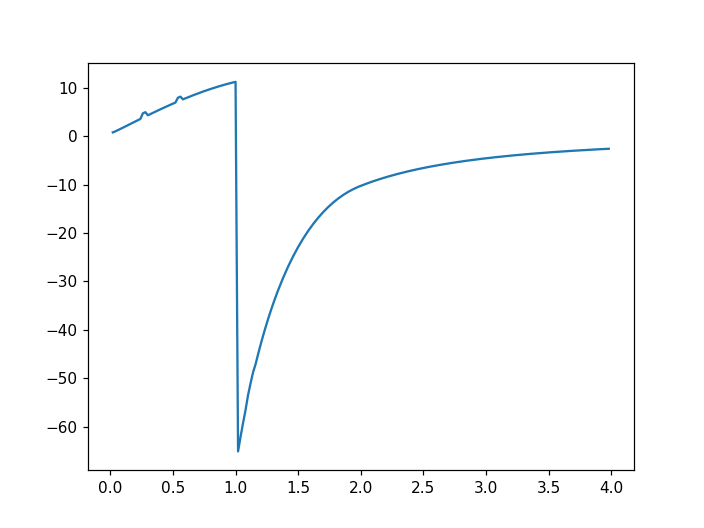

In [245]:
E_vec = E_r(r_vec)
plt.plot(r_vec, E_vec)
plt.show()
# artifically test
E_vec[0] = 0


<IPython.core.display.Javascript object>


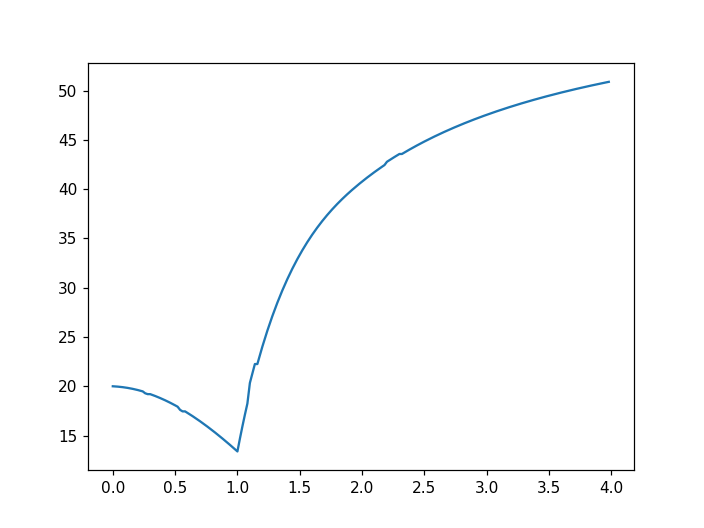

In [246]:
Phi_vec = Phi_r(r_vec, E_vec)
plt.plot(r_vec, Phi_vec)
plt.show()
#print(Phi_vec)

<IPython.core.display.Javascript object>


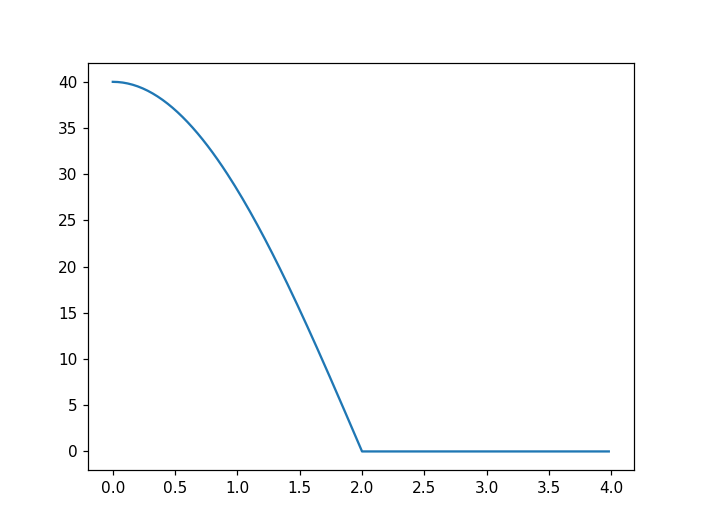

In [247]:
plt.plot(r_vec, v_rho_init(r_vec, R_anode, R_anode, Amp))
plt.show()

In [283]:
def get_E_and_close_pos(pos, r_vec, E_vec):
    index = -1 # Temperary holder
    reflection = False # reflection operation is not needed 
    if (pos <= np.max(r_vec)) and (pos >= 0):
        for i in range(r_vec.shape[0] - 1):   # end at shape - 1 because we check the end + 1
            if ( (pos > r_vec[i]) and (pos < r_vec[i + 1]) ):
                index = np.where(r_vec == r_vec[i])
                break
            elif pos == r_vec[i]:
                index = np.where(r_vec == r_vec[i])
                break
            elif pos == r_vec[i + 1]:
                index = np.where(r_vec == r_vec[i + 1])
                break
                
    elif (pos < 0) and (pos > -np.max(r_vec)):
        reflection = True
        pos = abs(pos)
        for i in range(r_vec.shape[0] - 1):   # end at shape - 1 because we check the end + 1
            if ( (pos > r_vec[i]) and (pos < r_vec[i + 1]) ):
                index = np.where(r_vec == r_vec[i])
                break
            elif pos == r_vec[i]:
                index = np.where(r_vec == r_vec[i])
                break
            elif pos == r_vec[i + 1]:
                index = np.where(r_vec == r_vec[i + 1])
                break
        E = E_vec[index]
        close_pos = r_vec[index]
        return E, close_pos, index[0][0], reflection 

    else:
        print('The particle has left the domain')
        index = 'Left Domain'
        E = 'None'
        close_pos = 'None'
        return E, close_pos, index, reflection 
    E = E_vec[index]
    close_pos = r_vec[index]
    #print(index)
    return E, close_pos, index[0][0], reflection 

def loss_channel_check(pos):
    transparancy = .999
    collision_type = 'None'
    is_active_2 = True
    # Check for a collision with the anode
    n = 3 # the number of dr steps away from the grid that a grid collision needs to be considered
    if (pos > (R_anode - n*dr)) and (pos < (R_anode + n*dr) ):
        prob = 1 - transparancy
        rand = np.random.random([1])
        if rand < prob:
            collision_type = 'Anode'
            is_active_2 = False
            
    # Check for a collsion with the Cathode
    elif (pos > (R_cathode - n*dr)) and (pos < (R_cathode + n*dr) ):
        n = 3 # the number of dr steps away from the cathode grid that a collision needs to be 
        #considered
        prob = 1 - transparancy
        rand = np.random.random([1])
        if rand < prob:
            collision_type = 'Cathode'
            is_active_2 = False
        # set up model for stalk collision. Assume for now that it is a set probability when within the 
    # outer grid. 
    elif (pos < R_anode):
        p_stalk_colide = .01        
        p_got = np.random.random([1])
        if p_got < p_stalk_colide:
            collision_type = 'Stalk'
            is_active_2 = False
    # Set up a model for a fusion reaction, for now just give it a 1 in 100 chance when the particle
    # is inside the cathode 
        if (pos < R_cathode):
            p_fusion = .01
            p_got = np.random.random([1])
            if p_got < p_fusion:
                collision_type = 'Fusion'
                is_active_2 = False

    return collision_type, is_active_2

# Make a made up collision model where the probability of reaction is based on the density
# for now, just set the velocity to zero 
def collision(pos, velocity):
    prob_collision = .0001 * v_rho_init(pos, R_anode, R_anode, Amp)
    got_prob = np.random.random([1])
    if got_prob < prob_collision:
        velocity = 0
        return velocity
    else:
        return velocity 
        

In [284]:
init_pos = R_anode - dr

def move_particle(init_pos, init_veloc, r_vec, E_vec, dt):
    q = e
    pos = init_pos
    pos_vec = [pos]
    is_active = True
    velocity = init_veloc
    velocity_vec = [velocity]
    loss_mech = 'None'
    position_histogram = np.zeros(r_vec.shape[0])
    
    #create a dictunary to hold the kinetic energies. The keys are indexes 
    #corrisponding to the position vector and vales are np arrays with energies. 
    dic = {}
    for i in range(r_vec.shape[0]):
        dic[i] = np.array([])
    
    while is_active == True:
        E, close_pos, ind, reflect  = get_E_and_close_pos(pos, r_vec, E_vec)
        
        # if the particle left the domain, 
        if ind == 'Left Domain':
            is_active = False
            loss_mech = 'Left Domain'
            break
        
        # Process reflection 
        if reflect == True:
            velocity = -1 * velocity
            pos = abs(pos)
        
        # Check for collision and update velocity accordingly:
        
        velocity = collision(pos, velocity)  
            
        # update histogram using ind 
        
        position_histogram[ind] = position_histogram[ind] + 1
        
        # update kinetic energy histogram at close_pos
        KE = (1/2) * m_dueterium * (velocity**2)
        dic[ind] = np.append(dic[ind], KE)
        
        velocity_old = velocity
        velocity = velocity_old + (q/m_dueterium)*E*dt
        np.append(velocity_vec, velocity)
        #print(pos)
        pos_old = pos
        pos = pos_old + velocity * dt
        np.append(pos_vec, pos)
        
        loss_mech, is_active = loss_channel_check(pos)
        #print('check')
        
    return position_histogram, dic, loss_mech, pos_vec, velocity_vec 
        


In [285]:
# Building the main outer loop that controles particle creation and simulation, and holds the
# histograms 

Main_pos_histogram = np.zeros(r_vec.shape[0])
Main_velocity_dic = {}
for i in range(r_vec.shape[0]):
    Main_velocity_dic[i] = np.array([])
num_particles = 100 # Define the number of particles to be created and studied. 
init_pos = R_anode # for now initialize all particles at the anode 
init_V = 0 # start particle with initial velocity as zero 
for particle in range(num_particles):
    pos_hist, vel_dic, loss_m, pos_v, vel_v = move_particle(init_pos, init_V, r_vec, E_vec, dt)
    #print(loss_m)
    Main_pos_histogram += pos_hist # update the position historgram
    for i in range(r_vec.shape[0]):
        Main_velocity_dic[i] = np.append(Main_velocity_dic[i], vel_dic[i])
    percent_complete = (particle / num_particles) * 100 
    print('Progress: %.6f' % percent_complete, '%' )
    
        

 

Progress: 0.000000 %
Progress: 1.000000 %
Progress: 2.000000 %
Progress: 3.000000 %
Progress: 4.000000 %
Progress: 5.000000 %
Progress: 6.000000 %
Progress: 7.000000 %
Progress: 8.000000 %
Progress: 9.000000 %
Progress: 10.000000 %
Progress: 11.000000 %
Progress: 12.000000 %
Progress: 13.000000 %
Progress: 14.000000 %
Progress: 15.000000 %
Progress: 16.000000 %
Progress: 17.000000 %
Progress: 18.000000 %
Progress: 19.000000 %
Progress: 20.000000 %
Progress: 21.000000 %
Progress: 22.000000 %
Progress: 23.000000 %
Progress: 24.000000 %
Progress: 25.000000 %
Progress: 26.000000 %
Progress: 27.000000 %
Progress: 28.000000 %
Progress: 29.000000 %
Progress: 30.000000 %
Progress: 31.000000 %
Progress: 32.000000 %
Progress: 33.000000 %
Progress: 34.000000 %
Progress: 35.000000 %
Progress: 36.000000 %
Progress: 37.000000 %
Progress: 38.000000 %
Progress: 39.000000 %
Progress: 40.000000 %
Progress: 41.000000 %
Progress: 42.000000 %
Progress: 43.000000 %
Progress: 44.000000 %
Progress: 45.000000 

<IPython.core.display.Javascript object>


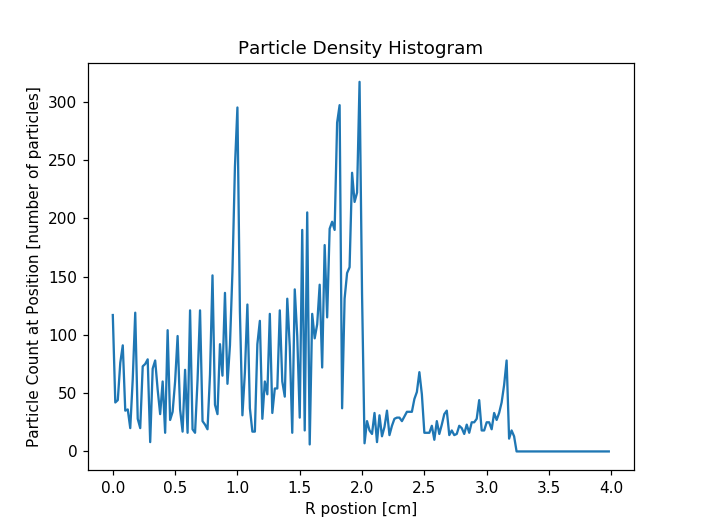

Text(0.5, 1.0, 'Particle Density Histogram')

In [286]:
# Main Test Results 
plt.plot(r_vec, Main_pos_histogram)
plt.xlabel('R postion [cm]')
plt.ylabel('Particle Count at Position [number of particles]')
plt.title('Particle Density Histogram')
#numBins = r_vec.shape[0]
#plt.hist(Main_pos_histogram, numBins,color='green',alpha=0.8)

In [13]:
 
pos_hit, dictionary, loss_m, pos_v, vel_v = move_particle(init_pos, 0, r_vec, E_vec, dt)

(array([99], dtype=int64),)
1.98
check
(array([98], dtype=int64),)
[1.97596856]
check
(array([98], dtype=int64),)
[1.96782298]
check


In [96]:
print(pos_hit)
print(loss_m)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Fusion


In [151]:
pos1 = 5
rvec1 = np.array([0, 1, 2, 3, 4, 5, 6])
Evec1 = np.array([0, 20, 21, 18, 15, 2, -6])

E, close, ind = get_E_and_close_pos(pos1, rvec1, Evec1)
print(E)
print(close)
print(ind)

[2]
[5]
5


In [103]:
dic = {}
for i in range(r_vec.shape[0]):
    dic[i] = np.array([])
dic[2] = np.append(dic[2], 3)
dic[2] = np.append(dic[2], 4)
dic

{0: array([], dtype=float64),
 1: array([], dtype=float64),
 2: array([3., 4.]),
 3: array([], dtype=float64),
 4: array([], dtype=float64),
 5: array([], dtype=float64),
 6: array([], dtype=float64),
 7: array([], dtype=float64),
 8: array([], dtype=float64),
 9: array([], dtype=float64),
 10: array([], dtype=float64),
 11: array([], dtype=float64),
 12: array([], dtype=float64),
 13: array([], dtype=float64),
 14: array([], dtype=float64),
 15: array([], dtype=float64),
 16: array([], dtype=float64),
 17: array([], dtype=float64),
 18: array([], dtype=float64),
 19: array([], dtype=float64),
 20: array([], dtype=float64),
 21: array([], dtype=float64),
 22: array([], dtype=float64),
 23: array([], dtype=float64),
 24: array([], dtype=float64),
 25: array([], dtype=float64),
 26: array([], dtype=float64),
 27: array([], dtype=float64),
 28: array([], dtype=float64),
 29: array([], dtype=float64),
 30: array([], dtype=float64),
 31: array([], dtype=float64),
 32: array([], dtype=float6

In [26]:
fvec = np.array([0, 1, 2, 3, 4])
print(fvec.shape[0])
for i in range(5):
    print(i)

5
0
1
2
3
4
